In [1]:
import numpy as np
import torch
import cv2
import seaborn as sns
import sys
sys.path.append('..')

from models import model_dict
from helper.sampling import langevin_at_x

# Get model and replay buffer

In [3]:
!ls /data/lijingru/EBKD/save/student_model/resnet28x10_cifar10_lr_0.0003_decay_0_buffer_size_40000_lpx_1.0_lpxy_0.0_energy_mode_mcmc_step_size_1_g_steps_20_trial_1

hyper		   res_epoch_120.pts  res_epoch_160.pts  res_epoch_200.pts
img_samples	   res_epoch_130.pts  res_epoch_170.pts  res_epoch_210.pts
res_epoch_100.pts  res_epoch_140.pts  res_epoch_180.pts  res_epoch_220.pts
res_epoch_110.pts  res_epoch_150.pts  res_epoch_190.pts  res_epoch_230.pts


In [4]:
!nvidia-smi

Thu Dec 23 20:14:01 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.67       CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 3090    Off  | 00000000:04:00.0 Off |                  N/A |
| 72%   65C    P2   329W / 350W |   7381MiB / 24268MiB |     89%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 3090    Off  | 00000000:05:00.0 Off |                  N/A |
| 83%   

| Wide-Resnet 28x10


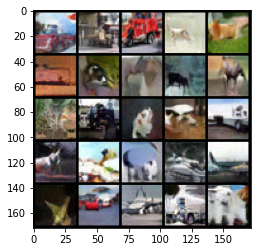

In [6]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils
device = "cuda:4"
model = model_dict['resnet28x10'](num_classes=10, norm='none', depth=28, widen_factor=10)
model = model_dict['Gen'](model, n_cls=10)
model = model.to(device)
save_path = '/data/lijingru/EBKD/save/student_model/resnet28x10_cifar10_lr_0.0003_decay_0_buffer_size_40000_lpx_1.0_lpxy_0.0_energy_mode_mcmc_step_size_1_g_steps_20_trial_1/'
ckpt_dict = torch.load(save_path + 'res_epoch_230.pts', map_location=device)
model.load_state_dict(ckpt_dict["model_state_dict"])
buffer_path = '/data/lijingru/EBKD/save/student_model/resnet28x10_cifar10_lr_0.0003_decay_0_buffer_size_40000_lpx_1.0_lpxy_0.0_energy_mode_mcmc_step_size_1_g_steps_20_trial_1/res_epoch_230.pts'
ckpt_dict = torch.load(buffer_path, map_location=device)
# print(ckpt_dict.keys())
replay_buffer = ckpt_dict["replay_buffer"]
sqrt = lambda x: int(torch.sqrt(torch.tensor([x])))
plot = lambda x: vutils.make_grid(torch.clamp(x, -1, 1), normalize=True, nrow=sqrt(x.size(0)))
buffer_size = len(replay_buffer)
inds = torch.randint(0, buffer_size, (25,))
sampled = replay_buffer[inds]
imgs = plot(sampled).cpu()
img = np.transpose(imgs, (1,2,0))
plt.figure(10)
plt.imshow(img)

### Calculate Inception Score and Options

In [7]:
import os
# save_path = '/data/lijingru/EBKD/save/student_model/resnet8x4_cifar100_lr_0.0001_decay_0.0_buffer_size_40000_lpx_0.0_lpxy_1.0_energy_mode_mcmc_step_size_5.0_trial_2_cls/'
if not os.path.exists(save_path):
    os.mkdir(save_path)



class Options:
    def __init__(self, save_grid=False):
        self.n_cls = 10
        self.save_folder = save_path
        if not save_grid:
            self.save_dir = os.path.join(save_path, 'img_sample_eval_imgs/')
#             self.save_dir = '/data/lijingru/EBKD/save/student_model/resnet28x10_cifar100_lr_0.0001_decay_0.0_buffer_size_40000_trial_fresh_deepinv_5_noreinit_epoch_3001_gsteps_40_step_size/img_sample_eval/'
        else:
            self.save_dir = os.path.join(save_path, 'img_sample_eval_grid/')
        self.save_grid = save_grid
        self.reinit_freq = 0.05
        self.batch_size = 64
        self.step_size = 1
        self.capcitiy = 40000
        self.n_sample_steps = 5
        self.print_every = 100
        self.dataset = 'svhn'
        self.g_steps = 40
#         self.reinit_freq = 0.
        



opt = Options()

print(opt.save_dir)
replay_buffer.size(0) / opt.n_cls

/data/lijingru/EBKD/save/student_model/resnet28x10_cifar10_lr_0.0003_decay_0_buffer_size_40000_lpx_1.0_lpxy_0.0_energy_mode_mcmc_step_size_1_g_steps_20_trial_1/img_sample_eval_imgs/


4000.0

## Visualize sample q
The visualization of $x \sim q_{\theta}$.

In [5]:
sample_q, _ = langevin_at_x(opt)
f_sample, samples = sample_q(model, replay_buffer, open_debug=True)
samples = torch.cat(samples, 0).cpu()
imgs = plot(samples)
img = np.transpose(imgs, (1,2,0))
plt.figure(10)
plt.imshow(img)

RuntimeError: Expected tensor for argument #1 'input' to have the same device as tensor for argument #2 'weight'; but device 0 does not equal 1 (while checking arguments for cudnn_convolution)

In [5]:
!rm -rf /data/lijingru/EBKD/save/student_model/resnet28x10_cifar100_lr_0.0002_decay_0_buffer_size_40000_lpx_1.0_lpxy_0.0_energy_mode_mcmc_step_size_1_g_steps_20_trial_2/img_sample_eval/

In [8]:
from helper.util_gen import cond_samples
opt = Options()
if not os.path.exists(opt.save_dir):
    os.mkdir(opt.save_dir)
# model.cuda()
cond_samples(model, replay_buffer, device, opt, use_buffer=True)

100%|██████████| 10/10 [08:39<00:00, 51.99s/it]

Successfully saving the generated result of replay buffer.
Successfully save the result.


tensor([[[[ 3.7891e-01,  3.9245e-01,  3.9124e-01,  ...,  3.2565e-01,
            3.1445e-01,  3.7044e-01],
          [ 3.6422e-01,  4.3307e-01,  4.3719e-01,  ...,  2.7069e-01,
            3.4859e-01,  3.0121e-01],
          [ 4.4916e-01,  4.6121e-01,  4.6688e-01,  ...,  3.4058e-01,
            2.9940e-01,  3.1726e-01],
          ...,
          [ 8.7527e-01,  2.0406e-01, -1.1552e-01,  ...,  9.4029e-01,
            9.1823e-01,  9.8367e-01],
          [ 4.5605e-01, -1.3282e-01, -1.0450e-01,  ...,  9.4445e-01,
            9.2087e-01,  9.4507e-01],
          [ 5.3572e-01,  5.3521e-02, -9.9164e-02,  ...,  9.9083e-01,
            1.0618e+00,  9.7852e-01]],

         [[ 2.6171e-01,  2.6136e-01,  3.1168e-01,  ...,  2.3186e-01,
            2.9972e-01,  2.3480e-01],
          [ 3.0558e-01,  2.4706e-01,  2.6561e-01,  ...,  2.9065e-01,
            2.5489e-01,  2.5928e-01],
          [ 3.6156e-01,  3.2845e-01,  2.4227e-01,  ...,  2.4829e-01,
            3.1712e-01,  2.8179e-01],
          ...,
     

In [9]:
from helper.util import inception_score
from datasets.cifar100 import CIFAR100Gen
import torchvision.transforms as T
if not opt.save_grid:
    test_folder = opt.save_dir
    dataset = CIFAR100Gen(
        root=test_folder,
        transform=T.Compose([
            T.ToTensor(),
            T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
        ])
    )
    mean, var = inception_score(dataset, device, resize=True, splits=3, batch_size=8)
    print(mean, var)
    
# print(os.listdir(test_folder))
print(len(os.listdir(test_folder)))

/data/lijingru/anaconda3/envs/torch/lib/python3.8/site-packages/torch/nn/functional.py:3454: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


5.962574635402508 0.028050460346577988
40000


In [9]:
os.listdir(test_folder)

['samples_label_8_60.png',
 'samples_label_17_11.png',
 'samples_label_55_37.png',
 'samples_label_1_65.png',
 'samples_label_98_15.png',
 'samples_label_66_81.png',
 'samples_label_6_60.png',
 'samples_label_91_34.png',
 'samples_label_31_22.png',
 'samples_label_7_73.png',
 'samples_label_5_20.png',
 'samples_label_14_13.png',
 'samples_label_75_56.png',
 'samples_label_26_15.png',
 'samples_label_97_31.png',
 'samples_label_52_74.png',
 'samples_label_81_73.png',
 'samples_label_69_60.png',
 'samples_label_41_20.png',
 'samples_label_52_22.png',
 'samples_label_43_123.png',
 'samples_label_92_31.png',
 'samples_label_87_61.png',
 'samples_label_29_15.png',
 'samples_label_94_27.png',
 'samples_label_99_49.png',
 'samples_label_95_66.png',
 'samples_label_56_68.png',
 'samples_label_81_53.png',
 'samples_label_62_68.png',
 'samples_label_32_78.png',
 'samples_label_17_7.png',
 'samples_label_73_74.png',
 'samples_label_81_58.png',
 'samples_label_90_85.png',
 'samples_label_53_35.png

In [15]:
# print(len(os.listdir(test_folder)))
from helper.util_gen import cond_samples
test_folder = opt.save_dir
print(test_folder)

optd = Options(save_grid=True)
cond_samples(model, replay_buffer, device, optd)

/data/lijingru/EBKD/save/student_model/cifar100_resnet28x10_cifar100_lr_0.0001_decay_0_buffer_size_10000_lpx_1.0_lpxy_0.0_energy_mode_mcmc_step_size_1_trial_short_refresh/img_sample_eval/


100%|██████████| 100/100 [00:04<00:00, 22.82it/s]

Successfully saving the generated result of replay buffer.


tensor([[[[ 1.0513e+00,  9.8224e-01,  9.6862e-01,  ...,  9.1669e-01,
            1.0614e+00,  1.4637e+00],
          [ 1.0047e+00,  9.3634e-01,  9.9040e-01,  ...,  8.0460e-01,
            1.0694e+00,  9.6850e-01],
          [ 1.0008e+00,  9.9291e-01,  9.5258e-01,  ...,  6.9197e-01,
            7.4473e-01,  8.3951e-01],
          ...,
          [ 1.0424e+00,  9.8448e-01,  8.2598e-01,  ...,  9.9922e-01,
            9.5964e-01,  9.5444e-01],
          [ 1.0386e+00,  9.4207e-01,  9.1723e-01,  ...,  9.9627e-01,
            9.6662e-01,  9.6769e-01],
          [ 1.3081e+00,  1.0199e+00,  9.7416e-01,  ...,  9.1009e-01,
            1.0027e+00,  1.1993e+00]],

         [[ 9.5454e-01,  9.7141e-01,  9.8044e-01,  ...,  1.0712e+00,
            1.2699e+00,  1.0907e+00],
          [ 1.0342e+00,  9.5942e-01,  9.6847e-01,  ...,  9.6750e-01,
            1.1363e+00,  1.2032e+00],
          [ 9.9090e-01,  9.6447e-01,  9.6487e-01,  ...,  7.6949e-01,
            8.5691e-01,  1.2097e+00],
          ...,
     

### t-SNE visualization

## Set options, datasets and dataloaders

In [13]:
from datasets.cifar100 import CIFAR100Gen, CIFAR100Instance
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from PIL import Image

test_folder = '/data/lijingru/cifar100/'
test_gen_folder = '/data/lijingru/img_sample_eval/'


test_list = [
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
]


# train_transform = transforms.Compose(train_list)
test_transform = transforms.Compose(test_list)
test_positive_set = CIFAR100Instance(root=test_folder, download=True, train=False, transform=test_transform)
test_negative_set = CIFAR100Gen(root=opt.save_dir, transform=test_transform, return_target=True)

test_p_loader = DataLoader(dataset=test_positive_set, batch_size=1, shuffle=False, num_workers=8)
test_n_loader = DataLoader(dataset=test_negative_set, batch_size=1, shuffle=False, num_workers=8)

Files already downloaded and verified


In [14]:
import tqdm
model.eval()
p_energys = []
q_energys = []
correct = 0
p_predict = []
for idx, data in tqdm.tqdm(enumerate(test_p_loader)):
    x, y, i = data
    x = x.to(device)
    y = y.to(device)
    logit = model(x=x, cls_mode=True)
    indexs = torch.argmax(logit, 1)
    p_predict += indexs.tolist()
    b_correct = torch.sum(indexs == y).item()
    correct += b_correct
    f = torch.gather(logit, 1, y[:, None]).mean()
    
    f = model(x=x, y=y)[0].mean()
    p_energys.append(f.item())
    
print('Positive Samples:')
print('Max: {:.4f}'.format(max(p_energys)))
print('Min: {:.4f}'.format(min(p_energys)))
print('Mean: {:.4f}'.format(sum(p_energys) / len(p_energys)))
print('Acc: {:.4f}'.format(correct / len(test_p_loader)))

for idx, data in tqdm.tqdm(enumerate(test_n_loader)):
    x, y, i = data
    x = x.to(device)
    y = y.to(device)
    
    f = model(x=x, y=y)[0].mean()
    q_energys.append(f.item())
    


print('Negative Samples:')
print('Max: {:.4f}'.format(max(q_energys)))
print('Min: {:.4f}'.format(min(q_energys)))
print('Mean: {:.4f}'.format(sum(q_energys) / len(q_energys)))

10000it [02:20, 70.95it/s]

Positive Samples:
Max: 22.9258
Min: -15.6754
Mean: 0.4314
Acc: 0.5622



50000it [06:33, 127.09it/s]

Negative Samples:
Max: 23.6816
Min: -16.8033
Mean: 1.4153


In [15]:
np.save(os.path.join(opt.save_folder, 'pxy_energy.npy'), np.asarray(p_energys))
np.save(os.path.join(opt.save_folder, 'qxy_energy.npy'), np.asarray(q_energys))

## Plot the distribution of energy function
$x^+ \sim p_{data}$, and $x^- \sim q_{\theta}$. If the EBM is well-trained, the plotted distribution should be close enough.

Here presented the distribution of conditional generation $p_{\theta}(x | y)$.

In [16]:
# If you have saved the energy value..
p_energys = np.load(os.path.join(opt.save_folder, 'pxy_energy.npy'))
q_energys = np.load(os.path.join(opt.save_folder, 'qxy_energy.npy'))

<AxesSubplot:ylabel='Density'>

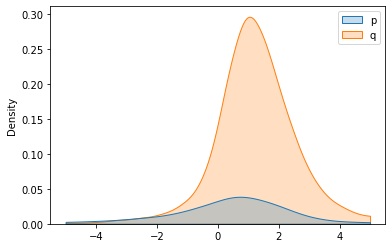

In [17]:
sns.kdeplot(data={'p':p_energys, 'q':q_energys}, clip=(-5, 5), fill=True)

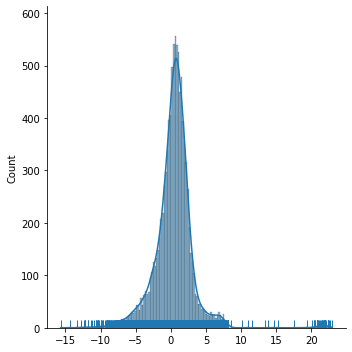

In [18]:
sns.displot(x=p_energys, kde=True, rug=True)

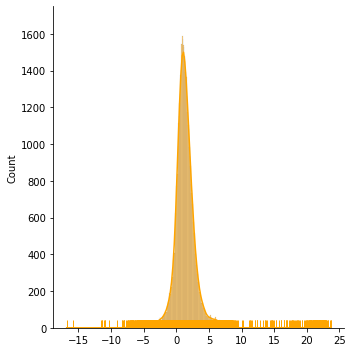

In [19]:
sns.displot(x=q_energys, color='orange', rug=True, kde=True)

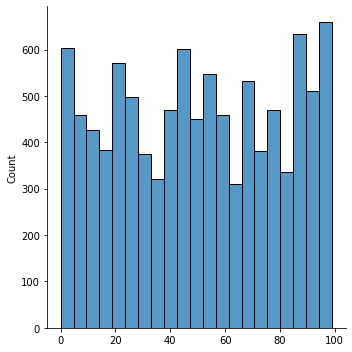

In [20]:
sns.displot(x=p_predict)

## Unconditional energy distribution
Considering the distribution of unconditional generation $p_{\theta}(x)$.

In [21]:
model.eval()
p_energys = []
q_energys = []
for idx, data in tqdm.tqdm(enumerate(test_p_loader)):
    x, y, i = data
    x = x.to(device)
    y = y.to(device)
    
    f = model(x=x)[0].mean()
    p_energys.append(f.item())
    
print('Positive Samples:')
print('Max: {:.4f}'.format(max(p_energys)))
print('Min: {:.4f}'.format(min(p_energys)))
print('Mean: {:.4f}'.format(sum(p_energys) / len(p_energys)))

for idx, data in tqdm.tqdm(enumerate(test_n_loader)):
    x, y, i = data
    x = x.to(device)
    y = y.to(device)
    
    f = model(x=x)[0].mean()
    q_energys.append(f.item())
    


print('Negative Samples:')
print('Max: {:.4f}'.format(max(q_energys)))
print('Min: {:.4f}'.format(min(q_energys)))
print('Mean: {:.4f}'.format(sum(q_energys) / len(q_energys)))

10000it [01:21, 122.62it/s]

Positive Samples:
Max: 22.9258
Min: -10.5952
Mean: 2.0310



50000it [06:42, 124.35it/s]

Negative Samples:
Max: 23.6816
Min: -16.5477
Mean: 1.9799


In [22]:
np.save(os.path.join(opt.save_folder, 'px_energy.npy'), np.asarray(p_energys))
np.save(os.path.join(opt.save_folder, 'qx_energy.npy'), np.asarray(q_energys))

In [23]:
# If you have saved energy value
p_energys = np.load(os.path.join(opt.save_folder, 'px_energy.npy'))
q_energys = np.load(os.path.join(opt.save_folder, 'qx_energy.npy'))

<AxesSubplot:ylabel='Density'>

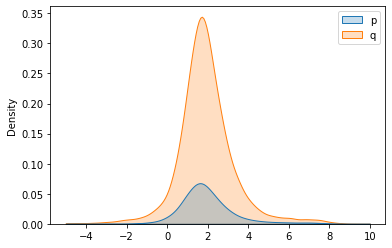

In [24]:
sns.kdeplot(data={'p':p_energys, 'q':q_energys}, clip=(-5, 10), fill=True)

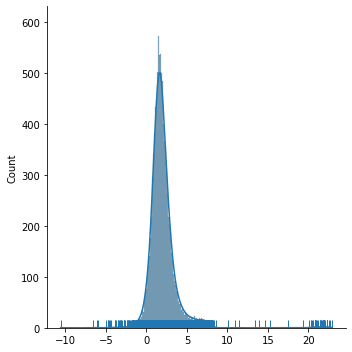

In [25]:
sns.displot(x=p_energys, kde=True, rug=True)

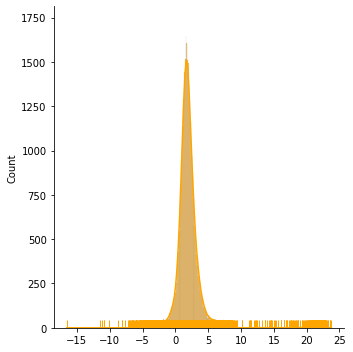

In [26]:
sns.displot(x=q_energys, color='orange', rug=True, kde=True)

In [9]:
f = open(os.path.join(opt.save_folder, 'best.txt'), 'a+')
f.write('best_result:{:.4f} +- {:.4f}'.format(mean, var))
f.close()